## Setup Instructions
- Ignore this if you already configured a python environment with required dependencies and have a **local** installation of fiji ImageJ.
- Follow setup instruction on [ImageJ Github page](https://github.com/imagej/pyimagej) on creating an environment and install pyImageJ. You can choose not to use `mamba` as in the document, but using it will save a bunch of time and get rid of many nontrivial debugging issues. Note that a Java JDK is also required to run ImageJ.
- After setup, restart the computer and try to activate the environment. If `print(os.environ['JAVA_HOME'])` prints the corresponding python library path, then you can proceed to the next step.
- Install latest [Fiji ImageJ](https://imagej.net/software/fiji/) on your computer. Change the following `app_path` to point to where your `fiji` folder resides.

## Section 1. Stabilizer

- read in raw input tif image sequence and pass through [fiji ImageJ](https://imagej.net/software/fiji/) [Image_Stabilizer](https://imagej.net/plugins/image-stabilizer) plugin
- This jupyter notebook requires you have a **local** installation of the latest imagej.
- Download the modified version of the plugin, `Image_Stabilizer_Headless.java`, and move it under the folder of `fiji/plugin`. To verify it is working, restart ImageJ and check if `Image Stabilizer Headless` appears under `Plugins` drop down menu.
- You don't need to open ImageJ while running this section.

In [1]:
from pipeline_source import *
import numpy as np
import imagej, scyjava
from scyjava import jimport
import os, sys, time
import cv2, tifffile

#### Initialize ImageJ

In [2]:
app_path = "D:\\CanYing\\Fiji.app"  # Change this to the directory to local imagej
ij = imagej.init(app_path, mode="interactive")
"""
Ignore the following errors if any when executing this cell:
java.lang.ClassNotFoundException: loci.formats.in.URLReader
java.lang.ClassNotFoundException: loci.formats.in.SlideBook6Reader
java.lang.ClassNotFoundException: loci.formats.in.ScreenReader
java.lang.ClassNotFoundException: loci.formats.in.ZarrReader
"""
print(f"ImageJ version: {ij.getVersion()}")
# if any error occurs executing following cells, check if fiji is the latest version.

ImageJ version: 2.3.0/1.53q


#### Choose between image sequence or a single movie:

In [3]:
# False if a sequence of tif images, True if a single tif movie
seq_movie_r = True
# Change fpath_in to the path to the folder if use image sequence, or path to the movie.
fpath_in = "E:\\case1 Movie_57.tif" # fpath_in = "D:\\CanYing\\Code\\Columbia\\tiny"
FolderOpener = jimport("ij.plugin.FolderOpener")

In [ ]:
if not seq_movie_r:
    imp = FolderOpener.open(fpath_in, "")
else:
    imp = ij.IJ.openImage(fpath_in)
dims = imp.getDimensions()
print(f"Loading images with width * height: [{dims[0]} * {dims[1]}], total of {dims[3]} slices.")

#### Run Image_Stabilizer

In [ ]:
#movie 57 ~360 rotation
# Choose the params you want to pass to the stabilizer
Transformation = "Translation"  # or "Affine"
MAX_Pyramid_level = 1
update_coefficient = 0.90
MAX_iteration = 200
error_tolerance = 1E-7

In [ ]:
stime = time.time()
ij.IJ.run(imp, "Image Stabilizer Headless",
       "transformation=" + Transformation + " maximum_pyramid_levels=" + str(MAX_Pyramid_level) +
       " template_update_coefficient=" + str(update_coefficient) + " maximum_iterations=" + str(MAX_iteration) +
       " error_tolerance=" + str(error_tolerance))
print(f"Task finishes. Total of {int((time.time() - stime) // 60)} m {int((time.time() - stime) % 60)} s.")

#### Save **stabilized** tif image sequence to a desired **empty** directory

In [4]:
# False if a sequence of tif images, True if a single tif movie
seq_movie_w = True
# Filepath to the empty directory if save to a sequence, or the tiff movie name if save to a single movie
fpath_out = "E:\\case1 Movie_57_stabilized.tif"     # You don't have to specify individual name if saving to image sequence, just to an empty folder

In [ ]:
if not seq_movie_w:
    # Adjust number of 0s in "/out_0s1.tif" for different number of images in the sequence
    ij.IJ.run(imp, "Image Sequence... ", "format=TIFF save=[" + fpath_out + "]")  # + "/out_0001.tif" + "]")
else:
    ij.IJ.saveAs(imp, "Tiff", fpath_out)

imp.close()

#### For Quality Control

In [ ]:
# False if a sequence of tif images, True if a single tif movie
seq_movie_gt = True
# Filepath to the empty directory if save to a sequence, or the tiff movie name if save to a single movie
fpath_gt = "E:\\Stablized_case1 Movie_57.tif" # You don't have to specify individual name if saving to image sequence, just to an empty folder

In [ ]:
# if not seq_movie_gt:
#     groundtruth_imp = FolderOpener.open(fpath_gt, "")
# else:
#     print(f"Opening input movie...")
#     groundtruth_imp = ij.IJ.openVirtual(fpath_gt)
# dims = groundtruth_imp.getDimensions()
# print(f"Loading ground truth images with width * height: [{dims[0]} * {dims[1]}], total of {dims[3]} slices.")
if not seq_movie_r:
    original_imp = FolderOpener.open(fpath_in, "")
else:
    print(f"Opening input movie...")
    original_imp = ij.IJ.openVirtual(fpath_in)
dims = original_imp.getDimensions()
print(f"Loading original images with width * height: [{dims[0]} * {dims[1]}], total of {dims[3]} slices.")
if not seq_movie_w:
    processed_imp = FolderOpener.open(fpath_out, "")
else:
    print(f"Opening output movie...")
    processed_imp = ij.IJ.openVirtual(fpath_out)
dims = processed_imp.getDimensions()
print(f"Loading processed images with width * height: [{dims[0]} * {dims[1]}], total of {dims[3]} slices.")

ij.ui().show(original_imp)
ij.ui().show(processed_imp)
ij.IJ.run("Synchronize Windows", "")

In [ ]:
# Closing all Images
# if groundtruth_imp is not None:
#     groundtruth_imp.close()
#     groundtruth_imp = None
if original_imp is not None:
    original_imp.close()
    original_imp = None
if processed_imp is not None:
    processed_imp.close()
    processed_imp = None

#### Resize Movie to save execution time and RAM for later parts.
- Note: The reason we don't crop the movie prior to stabilization is the unstabilized input may contain visible translation, which will the crop window much larger than stabilized one. To make sure the object is intact after cropping, we also need a lot of computing resources and time to determine frame by frame, which is not a good idea.

In [13]:
fpath_out = r"E:/Case3 Movie_59.tif"
imp = ij.io().open(fpath_out)
image = ij.py.from_java(imp)
image = np.array(image)

In [14]:
histogram = generate_histogram(image, 0)
threshold = find_threshold(histogram)
print(f"segmenting image with threshold {threshold}.")
img_seg = apply_segmentation(image, 0, threshold, True)
x1, y1, x2, y2 = find_bb_3D(img_seg, stride=500)
print(f"cropping original image with upper-left corner at ({y1}, {x1}); lower-right corner at ({y2}, {x2}).")

segmenting image with threshold 32.
cropping original image with upper-left corner at (288, 119); lower-right corner at (988, 819).


#### You can inspect the crop ROI with running the code cell below:

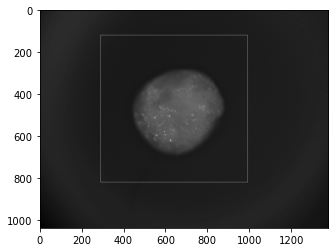

In [15]:
img = cv2.rectangle(image[0, ...], (y1, x1), (y2, x2), color=(255, 0, 0))
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

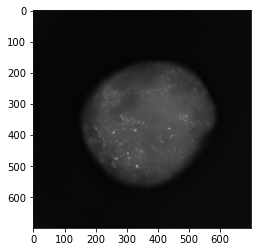

In [16]:
image_plt = image[:, x1:x2, y1:y2]
plt.figure()
plt.imshow(image_plt[0,...], cmap='gray')
plt.show()
# print(f"Cropping images with width * height: [{dims[0]} * {dims[1]}], total of {dims[3]} slices.")

In [ ]:
fpath_resize = r"E:/resized_case1.tif"
tifffile.imwrite(fpath_resize, image_plt)

#### Save cropped movie to file if needed.

In [ ]:
fpath_resize = r"E:/resized_case1.tif"
ij.IJ.saveAs(imp, "Tiff", fpath_resize)
imp.close()

#### Quality control for auto-cropping

In [ ]:
imp_before = ij.IJ.openVirtual(fpath_out)
imp_after = ij.IJ.openVirtual(fpath_resize)
ij.ui().show(imp_before)
ij.ui().show(imp_after)
ij.IJ.run("Synchronize Windows", "")

## Section 2. CaImAn
#### Note:
Due to incompatibility issue, code block at the end of this section may **not** run correctly. Please see Notes under `Reconstruct Denoised Movie` to make sure **your next half an hour of running the following code is meaningful!**

In [ ]:
import logging
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)
import caiman as cm
import matplotlib.pyplot as plt
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr, nb_inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import cv2

# try:
#     cv2.setNumThreads(0)
# except:
#     pass
import bokeh.plotting as bpl
import holoviews as hv
bpl.output_notebook()
hv.notebook_extension('bokeh')

### Select file(s) to be processed
The `download_demo` function will download the specific file for you and return the complete path to the file which will be stored in your `caiman_data` directory. If you adapt this demo for your data make sure to pass the complete path to your file(s). Remember to pass the `fnames` variable as a list. Note that the memory requirement of the CNMF-E algorithm are much higher compared to the standard CNMF algorithm. Test the limits of your system before trying to process very large amounts of data.

In [ ]:
fnames = ['E:\\Crop_Movie_57_stabilized.tif']  # filename to be processed
#fnames = [download_demo(fnames[0])]

### Setup some parameters
We first set some parameters related to the data and motion correction and create a `params` object. We'll modify this object with additional settings later on. You can also set all the parameters at once as demonstrated in the `demo_pipeline.ipynb` notebook.

In [ ]:
# dataset dependent parameters
frate = 10                       # movie frame rate
decay_time = 0.4                 # length of a typical transient in seconds

# motion correction parameters
motion_correct = False    # flag for performing motion correction
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)       # size of high pass spatial filtering, used in 1p data
max_shifts = (5, 5)      # maximum allowed rigid shift
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries

mc_dict = {
    'fnames': fnames,
    'fr': frate,
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
}

opts = params.CNMFParams(params_dict=mc_dict)

### Motion Correction
The background signal in micro-endoscopic data is very strong and makes the motion correction challenging.
As a first step the algorithm performs a high pass spatial filtering with a Gaussian kernel to remove the bulk of the background and enhance spatial landmarks.
The size of the kernel is given from the parameter `gSig_filt`. If this is left to the default value of `None` then no spatial filtering is performed (default option, used in 2p data).
After spatial filtering, the NoRMCorre algorithm is used to determine the motion in each frame. The inferred motion is then applied to the *original* data so no information is lost.

The motion corrected files are saved in memory mapped format. If no motion correction is being performed, then the file gets directly memory mapped.

In [ ]:
if motion_correct:
    # do motion correction rigid
    mc = MotionCorrect(fnames, dview=None, **opts.get_group('motion'))
    mc.motion_correct(save_movie=True)
    fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(np.int)
    else:
        bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)
        plt.subplot(1, 2, 1); plt.imshow(mc.total_template_rig)  # % plot template
        plt.subplot(1, 2, 2); plt.plot(mc.shifts_rig)  # % plot rigid shifts
        plt.legend(['x shifts', 'y shifts'])
        plt.xlabel('frames')
        plt.ylabel('pixels')

    bord_px = 0 if border_nan is 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='memmap_', order='C',
                               border_to_0=bord_px)
else:  # if no motion correction just memory map the file
    bord_px = 0
    fname_new = cm.save_memmap(fnames, base_name='memmap_',
                               order='C', border_to_0=0, dview=None)

### Load memory mapped file

In [ ]:
# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

### Parameter setting for CNMF-E
We now define some parameters for the source extraction step using the CNMF-E algorithm.
We construct a new dictionary and use this to modify the *existing* `params` object,

In [ ]:
# parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None
gSig = (3, 3)       # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = (13, 13)     # average diameter of a neuron, in general 4*gSig+1
Ain = None          # possibility to seed with predetermined binary masks
merge_thr = .7      # merging threshold, max correlation allowed
rf = 40             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 20    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 2            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                     True performs global low-rank approximation if gnb>0
gnb = 0             # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb= 0: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb<-1: Don't return background
nb_patch = 0        # number of background components (rank) per patch if gnb>0,
#                     else it is set automatically
min_corr = .8       # min peak value from correlation image
min_pnr = 5        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor

opts.change_params(params_dict={'method_init': 'corr_pnr',  # use this for 1 photon
                                'K': K,
                                'gSig': gSig,
                                'gSiz': gSiz,
                                'merge_thr': merge_thr,
                                'p': p,
                                'tsub': tsub,
                                'ssub': ssub,
                                'rf': rf,
                                'stride': stride_cnmf,
                                'only_init': True,    # set it to True to run CNMF-E
                                'nb': gnb,
                                'nb_patch': nb_patch,
                                'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
                                'low_rank_background': low_rank_background,
                                'update_background_components': True,  # sometimes setting to False improve the results
                                'min_corr': min_corr,
                                'min_pnr': min_pnr,
                                'normalize_init': False,               # just leave as is
                                'center_psf': True,                    # leave as is for 1 photon
                                'ssub_B': ssub_B,
                                'ring_size_factor': ring_size_factor,
                               }
                  )

### Inspect summary images and set parameters
Check the optimal values of `min_corr` and `min_pnr` by moving slider in the figure that pops up. You can modify them in the `params` object.
Note that computing the correlation pnr image can be computationally and memory demanding for large datasets. In this case you can compute
only on a subset of the data (the results will not change). You can do that by changing `images[::1]` to `images[::5]` or something similar.
This will compute the correlation pnr image

In [ ]:
# compute some summary images (correlation and peak to noise)
cn_filter, pnr = cm.summary_images.correlation_pnr(images[::10], gSig=gSig[0], swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
nb_inspect_correlation_pnr(cn_filter, pnr)

You can inspect the correlation and PNR images to select the threshold values for `min_corr` and `min_pnr`. The algorithm will look for components only in places where these value are above the specified thresholds. You can adjust the dynamic range in the plots shown above by choosing the selection tool (third button from the left) and selecting the desired region in the histogram plots on the right of each panel.

In [ ]:
# print parameters set above, modify them if necessary based on summary images
print(min_corr) # min correlation of peak (from correlation image)
print(min_pnr)  # min peak to noise ratio

### Run the CNMF-E algorithm

In [ ]:
cnm = cnmf.CNMF(n_processes=6, dview=None, Ain=Ain, params=opts)
cnm.fit(images)

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>
After setting some parameters we again modify the existing `params` object.

In [ ]:
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

min_SNR = 3  # adaptive way to set threshold on the transient size
r_values_min = 0.85  # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': r_values_min,
                           'use_cnn': False})
cnm.estimates.evaluate_components(images, cnm.params, dview=None)

print(' ***** ')
print('Number of total components: ', len(cnm.estimates.C))
print('Number of accepted components: ', len(cnm.estimates.idx_components))

### Do some plotting

In [ ]:
cnm.estimates.plot_contours_nb(img=cn_filter, idx=cnm.estimates.idx_components)

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [ ]:
# accepted components
cnm.estimates.hv_view_components(img=cn_filter, idx=cnm.estimates.idx_components,
                                denoised_color='red', cmap='gray')

In [ ]:
# rejected components
cnm.estimates.hv_view_components(img=cn_filter, idx=cnm.estimates.idx_components_bad,
                                denoised_color='red', cmap='gray')

In [ ]:
myidx = cnm.estimates.idx_components
print(len(myidx))

(x,y) = cnm.estimates.A.shape
print(y)

### Some instructive movies
Play the reconstructed movie alongside the original movie and the (amplified) residual

In [ ]:
# with background
cnm.estimates.play_movie(images, q_max=99.5, magnification=2,
                                 include_bck=True, gain_res=10, bpx=bord_px)

In [ ]:
# without background
cnm.estimates.play_movie(images, q_max=99.9, magnification=2,
                                 include_bck=False, gain_res=4, bpx=bord_px)

## Get alll detected spatial components

In [ ]:
import numpy as np

(x, y) = cnm.estimates.A.shape
# the index of accepted components
myidx = cnm.estimates.idx_components

coordinate1 = np.reshape(cnm.estimates.A[:, myidx[1]].toarray(), dims, order='F')
bl = coordinate1 > 0

# setup blank merge arrays. One is from merge, the other is from overlapped areas
merged = np.where(bl == True, 0, coordinate1)
mhits = np.where(bl == True, 0, coordinate1)
blm = merged > 0

for i in myidx:
    coordinate2 = np.reshape(cnm.estimates.A[:, i].toarray(), dims, order='F')
    #%% generate boolean indexing
    bl2 = coordinate2 > 0
    ct2 = np.sum(bl2)
    blm = merged > 0
    # identify the overlapped components
    bli = np.logical_and(bl2, blm)
    cti = np.sum(bli)
    # calculate the portion of the overlapped
    percent = cti / ct2
    print(percent)
    if percent < 0.25:
        # change the label of this component
        merged = np.where(bl2 == True, i + 1, merged)
        # exclude the overlapped areas
        merged = np.where(bli == True, 0, merged)
    else:
        # put the overlapped areas here
        mhits = np.where(bli == True, 999 + i, mhits)

np.savetxt("E://coor_merged.csv", merged, delimiter=",")
np.savetxt("E://coor_mhits.csv", mhits, delimiter=",")

### Extract DF/F values

In [ ]:
(components,frames) = cnm.estimates.C.shape
print(frames)
cnm.estimates.detrend_df_f(quantileMin=8, frames_window=frames)
cnm.estimates

## Modify the segmentation file of FluoroSNNAP

In [ ]:
# import scipy.io
# import numpy as np
#
# # loat matlab .mat into a dictionary
# mat = scipy.io.loadmat("E:\\caiman_data\\caiman2fluro\\Segmentation-template.mat")
# # access variable
# mat["L"].shape
# # remove variable
# # save it
#
# data = np.genfromtxt('E:\\caiman_data\\demos\\notebooks\\coor_merged.csv', delimiter=',')
# data.shape
# mat["L"] = data
# scipy.io.savemat('E:\\caiman_data\\caiman2fluro\\pthyon_out_coor_merged.mat', mat)

## Visualize a component

In [ ]:
i = 91
plt.figure()
plt.imshow(np.reshape(cnm.estimates.A[:, i].toarray(), dims, order='F'))
plt.figure()
plt.plot(cnm.estimates.C[i])

In [ ]:
i = 91
plt.figure()
plt.imshow(np.reshape(cnm.estimates.A[:, i].toarray(), dims, order='F'))
plt.figure()
plt.plot(cnm.estimates.C[i])

## reconstruct denoised movie
#### Note: If the following code returns error complaining about an nonexistent parameter called `compress`, that is due to library incompatibility issue. Change code under caiman library file to make the parameter from `compress` to `compression`, and rerun CalmAn all over again.

#### Details: The following file paths refer to your conda library path: For example, C:\Users\canying\\.conda\env\caiman\Lib\site-packages\
- Under `caiman/base/timeseries.py`, between line 173-191: `tif.write()` and `tif.save()` may complain parameter `compress`.
- Please make sure the parameter within your library is compatible with follows:
- In `tiffle/tiffle.py`, line 1440 and line 3084: The function may contain `compression` instead of `compress`. If this is the case, change code under `caiman/base/timeseries.py` from `compress=compress` to `compression=compress`.

In [ ]:
denoised = cm.movie(cnm.estimates.A.dot(cnm.estimates.C)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])

In [ ]:
denoised.save('E:\\denoised.tif')